In [1]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms



# **PRETRAITEMENT**

In [2]:
#  1. Configuration des chemins
DATA_DIR = '/kaggle/input/wikiart'
IMAGE_SIZE = 256  # Ou 512 selon la RAM / GPU

#  2. Définir la transformation (prétraitement)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # Normalise entre [0,1]
    transforms.Lambda(lambda x: x * 2 - 1)  # Normalise entre [-1,1]
])

# 3. Créer une Custom Dataset

class WikiArtDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = []
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    self.image_files.append(os.path.join(root, file))
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image


In [3]:
#  4. Charger le dataset
dataset = WikiArtDataset(root_dir='/kaggle/input/wikiart', transform=transform)



# 5. Créer un DataLoader pour l'entraînement
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# Test de chargement
for batch in tqdm(dataloader, desc="Chargement des images"):
    print(batch.shape)  # (batch_size, 3, 256, 256)
    break  # Juste pour vérifier 1 batch

Chargement des images:   0%|          | 0/5091 [00:00<?, ?it/s]

torch.Size([16, 3, 256, 256])


Chargement des images:   0%|          | 0/5091 [00:01<?, ?it/s]


In [5]:
from torchvision import transforms
from PIL import Image

IMAGE_SIZE = 256  # ou 512, selon ta config GPU

# Option 1 : normaliser dans [0, 1]
transform_0_1 = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),                # met les pixels dans [0,1]
    # (pas d'étape supplémentaire)
])

# Option 2 : normaliser dans [-1, 1]
transform_m11 = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),                # [0,1]
    transforms.Lambda(lambda x: x * 2 - 1)  # -> [-1,1]
])

# Exemple d'utilisation sur une image style
img = Image.open('/kaggle/input/wikiart/Impressionism/abdullah-suriosubroto_air-terjun.jpg').convert('RGB')

#  la transform  :

img_tensor_m11 = transform_m11(img)   # Tensor ∈ [-1,1]

  # doit afficher 0.0 et 1.0
print(img_tensor_m11.min(), img_tensor_m11.max())   # doit afficher environ -1.0 et 1.0


tensor(-0.9843) tensor(0.9922)


In [6]:
from torch.utils.data import DataLoader

dataset = WikiArtDataset(root_dir='/kaggle/input/wikiart', transform=transform_m11)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# test rapide
batch = next(iter(dataloader))
print(batch.shape)        # (16, 3, 256, 256)
print(batch.min(), batch.max())  # entre -1 et 1 si tu as choisi transform_m11


torch.Size([16, 3, 256, 256])
tensor(-1.) tensor(1.)


In [8]:
import torch
import torch.nn as nn

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.layer = nn.Sequential(
            nn.ReflectionPad2d(reflection_padding),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvLayer(channels, channels, 3, 1),
            ConvLayer(channels, channels, 3, 1)
        )

    def forward(self, x):
        return x + self.block(x)

class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.encoder = nn.Sequential(
            ConvLayer(3, 32, 9, 1),
            ConvLayer(32, 64, 3, 2),
            ConvLayer(64, 128, 3, 2),
        )
        self.residuals = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            ConvLayer(128, 64, 3, 1),
            nn.Upsample(scale_factor=2),
            ConvLayer(64, 32, 3, 1),
            ConvLayer(32, 3, 9, 1),
            nn.Tanh(),  # [-1, 1] output
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.residuals(x)
        x = self.decoder(x)
        return x


# **2 : Définir la perte (Loss)**

In [9]:
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn

class VGGFeatures(nn.Module):
    def __init__(self):
        super(VGGFeatures, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features
        self.relu1_2 = nn.Sequential(*vgg[:4])
        self.relu2_2 = nn.Sequential(*vgg[4:9])
        self.relu3_3 = nn.Sequential(*vgg[9:16])
        self.relu4_3 = nn.Sequential(*vgg[16:23])
        
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        out = {}
        out['relu1_2'] = self.relu1_2(x)
        out['relu2_2'] = self.relu2_2(out['relu1_2'])
        out['relu3_3'] = self.relu3_3(out['relu2_2'])
        out['relu4_3'] = self.relu4_3(out['relu3_3'])
        return out


**Fonction pour calculer la Gram Matrix (pour la perte de style) :**

In [10]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (c * h * w)


# **Partie 3 : Boucle d'entraînement simple**

In [16]:
import os

def save_checkpoint(transformer, optimizer, epoch, path="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': transformer.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def load_checkpoint(transformer, optimizer, path="checkpoint.pth"):
    if os.path.isfile(path):
        checkpoint = torch.load(path, map_location=device)
        transformer.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"✅ Checkpoint chargé, reprise à l'epoch {start_epoch}")
        return start_epoch
    else:
        print("ℹ️ Aucun checkpoint trouvé, entraînement depuis le début")
        return 0


In [17]:
# Charger checkpoint si disponible
start_epoch = load_checkpoint(transformer, optimizer)


ℹ️ Aucun checkpoint trouvé, entraînement depuis le début


In [18]:
for epoch in range(start_epoch, EPOCHS):
    transformer.train()
    pbar = tqdm(dataloader)
    for batch in pbar:
        optimizer.zero_grad()

        batch = batch.to(device)
        stylized_batch = transformer(batch)

        stylized_features = vgg(stylized_batch)
        original_features = vgg(batch)

        content_loss = mse_loss(stylized_features['relu2_2'], original_features['relu2_2'])

        style_loss = 0
        for layer in gram_style:
            stylized_gram = gram_matrix(stylized_features[layer])
            style_loss += mse_loss(stylized_gram, gram_style[layer])

        total_loss = content_loss + 1e5 * style_loss

        total_loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch+1} Loss: {total_loss.item():.4f}")

    # Sauvegarder après chaque epoch
    save_checkpoint(transformer, optimizer, epoch)
    print(f"💾 Sauvegarde effectuée après epoch {epoch+1}")


Epoch 1 Loss: 0.9989: 100%|█████████▉| 5090/5091 [34:35<00:00,  2.46it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([4, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([4, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([4, 256, 256])). This will likel

💾 Sauvegarde effectuée après epoch 1


Epoch 2 Loss: 0.8924: 100%|██████████| 5091/5091 [33:51<00:00,  2.51it/s]


💾 Sauvegarde effectuée après epoch 2


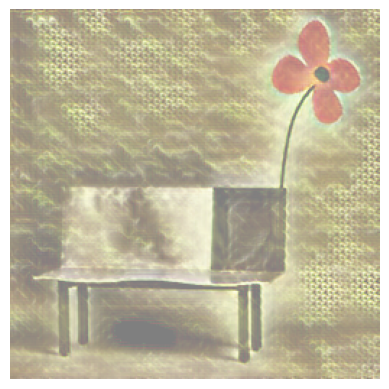

In [44]:
transformer.eval()

test_img = Image.open("/kaggle/input/wikiart/Pop_Art/aki-kuroda_flower-bench-2007.jpg")
test_tensor = transform(test_img).unsqueeze(0).to(device)

with torch.no_grad():
    output = transformer(test_tensor)

# Dé-normaliser pour afficher
output = output.squeeze(0).cpu()
output = output * 0.5 + 0.5  # Denormalize from [-1,1] to [0,1]
output = output.clamp(0, 1)

import matplotlib.pyplot as plt
plt.imshow(output.permute(1,2,0))
plt.axis('off')
plt.show()


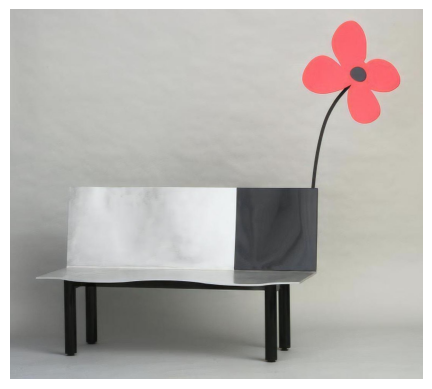

In [45]:

import matplotlib.pyplot as plt
plt.imshow(test_img)
plt.axis('off')
plt.show()


In [28]:
# Sauvegarde du modèle complet pour l'utiliser plus tard
model_save_path = "/kaggle/working/fast_style_transfer_model.pth"
torch.save(transformer.state_dict(), model_save_path)
print(f"✅ Modèle sauvegardé à {model_save_path}")


✅ Modèle sauvegardé à /kaggle/working/fast_style_transfer_model.pth


# ** Visualiser 5 images du DataLoader**

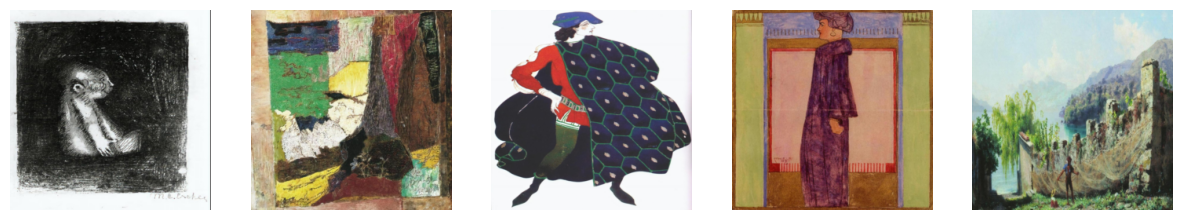

In [29]:
import matplotlib.pyplot as plt

# Une fonction pour "unnormalize" [-1,1] --> [0,1] pour affichage
def denormalize(img_tensor):
    img = (img_tensor + 1) / 2  # Inverse de x*2 - 1
    img = img.clamp(0, 1)  # Clamp entre [0,1]
    return img

# Afficher 5 images d'un batch
dataiter = iter(dataloader)
images = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize=(15,5))
for idx in range(5):
    img = denormalize(images[idx]).permute(1, 2, 0).cpu().numpy()
    axes[idx].imshow(img)
    axes[idx].axis('off')
plt.show()
